In [55]:
import os
import pathlib
import pickle

import numpy as np
import cv2
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
class Loader:
    def __init__(self, occ, noise, ind, img_num):
        self.occ = occ
        self.noise = noise
        self.img_num = img_num
        self.ind = ind
        
        def gen_path(occ, noise, ind, img_num):
            frechet_path = "frechet_csv/{}_{}_{}_{}_frechet.csv".format(occ, noise, ind, img_num)
            area_path = "frechet_csv/{}_{}_{}_{}_area.csv".format(occ, noise, ind, img_num)
            return frechet_path, area_path
        
        frechet_path, area_path = gen_path(occ, noise, ind, img_num)
        
        self.frechet_val = np.loadtxt(frechet_path, delimiter=',')
        self.area_val = np.loadtxt(area_path, delimiter=',')
    
    def PR_load(self):
        pre_path = "../PR/{}/{}/{}/{}_pre.pickle".format(self.occ, self.noise, self.ind, self.img_num)
        rec_path = "../PR/{}/{}/{}/{}_rec.pickle".format(self.occ, self.noise, self.ind, self.img_num)
        with open(pre_path, 'rb') as f:
            self.P = np.array(pickle.load(f))
        with open(rec_path, 'rb') as f:
            self.R = np.array(pickle.load(f))
        
    def prop_PR(self):
        sup_thes = list(range(self.img_num,-1,-4))[:int((len(list(range(self.img_num,-1,-4)))-1)*7/8)]
        global_true_idx = [np.where((self.P>0.99)[:,i])[0]
                           if np.where((self.P>0.99)[:,i])[0].size != 0 
                           else np.array([-1])
                           for i in range(self.P.shape[1])]
        local_opt_idx = [np.argmax(self.R[:,i][global_true_idx[i]]) for i in range(len(global_true_idx))]
        self.global_opt_idx = [g_idx[l_idx] for g_idx, l_idx in zip(global_true_idx, local_opt_idx)]
        self.proped_P = [self.P[idx,pos] for pos, idx in enumerate(self.global_opt_idx)]
        self.proped_R = [self.R[idx,pos] for pos, idx in enumerate(self.global_opt_idx)]
    
    def sum_leaf_img(self):
        image_folder = pathlib.Path("../images/{}/{}/{}".format(self.occ, self.ind, self.img_num))
        image_path_list = []
        for i in range(8):
            images_path = list(image_folder.glob("*_{}.png".format(i)))
            image_path_list.append(images_path)

        count_list = []
        px_num_sum_list = []
        for images_path in image_path_list:
            count, px_num_sum = count_leaf_img(images_path)
            count_list.append(count)
            px_num_sum_list.append(px_num_sum)
        self.px_num_sum_list = px_num_sum_list
        self.count_list = count_list
        
def count_leaf_img(images_path):
    count = 0
    px_num_sum = 0
    for path in images_path:
        img = cv2.imread(str(path), 0)
        px_num = np.sum(img > 0)
        if px_num > 0:
            count += 1
        px_num_sum += px_num
    return count, px_num_sum

In [76]:
image_folder = pathlib.Path("../images/{}/{}/{}".format("q_aothick", "q_1_a", 128))
image_path_list = []
for i in range(8):
    images_path = list(image_folder.glob("*_{}.png".format(i)))
    image_path_list.append(images_path)

count_list = []
px_num_sum_list = []
for images_path in image_path_list:
    count, px_num_sum = count_leaf_img(images_path)
    count_list.append(count)
    px_num_sum_list.append(px_num_sum)


In [62]:
np.sum(cv2.imread(str(image_path_list[0][0]), 0) > 0)

3770

In [46]:
image_folder

'../images/q_a/0mm/q_1_a/128'

In [85]:
l = Loader("q_a", "0mm", "q_1_a", 128)

In [86]:
l.PR_load()
l.prop_PR()
l.sum_leaf_img()


In [87]:
occs = ["q_a", "q_aothin", "q_aothick"]
noises = ["0mm", "1mm", "3mm"]
inds = ["q_1_a", "q_2_a", "q_3_a"]
img_nums = [128,64,32]

In [88]:
l_inputs = []
for noise in noises:
    for img_num in img_nums:
        for occ in occs:
            for ind in inds:
                l_inputs.append([occ, noise, ind, img_num])

In [89]:
l = []
for occ, noise, ind, img_num in l_inputs:
    lo = Loader(occ, noise, ind, img_num)
    lo.PR_load()
    lo.prop_PR()
    lo.sum_leaf_img()
    for frechet_val, area_val, P, R, count, px_num_sum in zip(lo.frechet_val, lo.area_val, lo.proped_P, lo.proped_R, lo.count_list, lo.px_num_sum_list):
        temp_l = [noise, img_num, area_val, frechet_val, P, R, count, px_num_sum, occ]
        l.append(temp_l)
l = np.array(l)

In [90]:
def dataset_discriminater(dataset):
    if dataset == "q_a":
        return "No pillars"
    elif dataset == "q_aothin":
        return "Thin pillars"
    else:
        return "Thick pillars"

In [91]:
dataset_list = [dataset_discriminater(dataset) for dataset in l[:,8]]

In [92]:
df = pd.DataFrame({
    'Noise' : l[:,0],
    'Image Number' : l[:,1].astype("int"),
    'Leaf Area' : np.round(l[:,2].astype("float"),decimals=2),
    'Standardized Frechet Distance': l[:,3].astype("float")/np.sqrt(l[:,2].astype("float")),
    "P": l[:,4],
    "R": l[:,5],
    "Reflected Image Number": l[:,6],
    "Total Number of Pixels": l[:,7],
    "Dataset" : dataset_list
    
    })

In [93]:
df

,Noise,Image Number,Leaf Area,Standardized Frechet Distance,P,R,Reflected Image Number,Total Number of Pixels,Dataset
0,0mm,128,3.09,0.027751,1.0,0.8294712712413415,128,1258044,No pillars
1,0mm,128,0.52,0.072763,1.0,0.8432055749128919,128,196346,No pillars
2,0mm,128,3.09,0.035043,1.0,0.8189079927913886,128,1186515,No pillars
3,0mm,128,1.57,0.039510,1.0,0.8106022896963664,128,575738,No pillars
4,0mm,128,0.68,0.062407,1.0,0.7905637390630191,128,259852,No pillars
...,...,...,...,...,...,...,...,...,...
643,3mm,32,1.57,0.073664,1.0,0.4301445285615967,28,136980,Thick pillars
644,3mm,32,0.68,0.098034,1.0,0.4702945581627559,32,64644,Thick pillars
645,3mm,32,1.57,0.079887,1.0,0.29145273331319843,24,155608,Thick pillars
646,3mm,32,3.09,0.073174,0.822,0.46099290780141844,27,339445,Thick pillars


In [94]:
df.to_csv('sim_data.csv')

In [33]:
e_df = df[(df["Noise"] == "0mm") & (df["Image Number"] == 128)]

In [34]:
e_df = df[(df["Noise"] == "0mm")]

In [35]:
g.axes

array([[<AxesSubplot:title={'center':'Noise = 0mm | Image Number = 32'}, xlabel='Leaf Area', ylabel='Standardized Frechet Distance'>,
        <AxesSubplot:title={'center':'Noise = 0mm | Image Number = 64'}>,
        <AxesSubplot:title={'center':'Noise = 0mm | Image Number = 128'}>],
       [<AxesSubplot:title={'center':'Noise = 1mm | Image Number = 32'}, ylabel='Standardized Frechet Distance'>,
        <AxesSubplot:title={'center':'Noise = 1mm | Image Number = 64'}>,
        <AxesSubplot:title={'center':'Noise = 1mm | Image Number = 128'}>],
       [<AxesSubplot:title={'center':'Noise = 3mm | Image Number = 32'}, xlabel='Leaf Area', ylabel='Standardized Frechet Distance'>,
        <AxesSubplot:title={'center':'Noise = 3mm | Image Number = 64'}, xlabel='Leaf Area'>,
        <AxesSubplot:title={'center':'Noise = 3mm | Image Number = 128'}, xlabel='Leaf Area'>]],
      dtype=object)

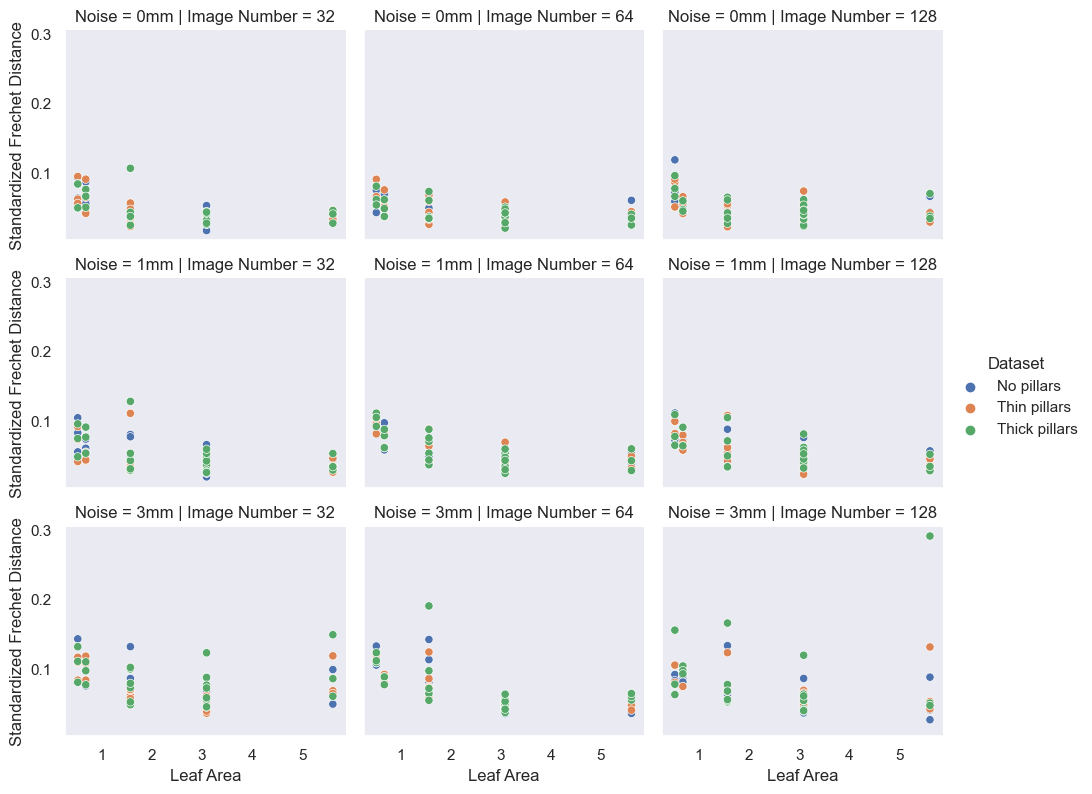

In [43]:
sns.set_theme(style="dark")


g = sns.relplot(
    data=df, kind="scatter",
    x="Leaf Area", y="Standardized Frechet Distance", col="Image Number", row="Noise",
    hue="Dataset",
    height=2.7, aspect=1.2, legend=True,
)
#g.set(ylim=(None,0.3))
#ax = sns.boxplot (x="Leaf Area", y="Standardized Frechet Distance",data=df, ax=g.axes[0,0])

<AxesSubplot:xlabel='Leaf Area', ylabel='Standardized Frechet Distance'>

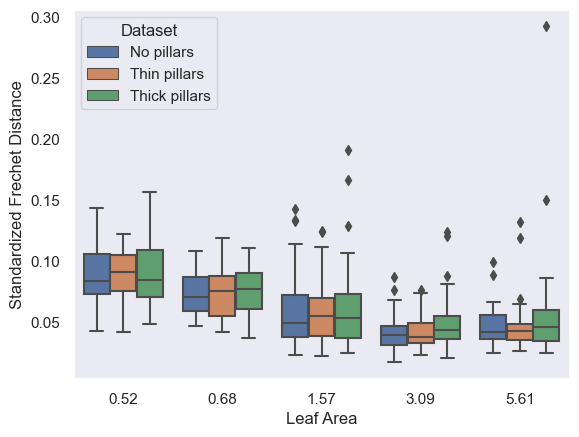

In [44]:
sns.boxplot(data=df,x="Leaf Area", y="Standardized Frechet Distance", hue="Dataset")

In [64]:
row_list[::-1]

array([ 32,  64, 128])

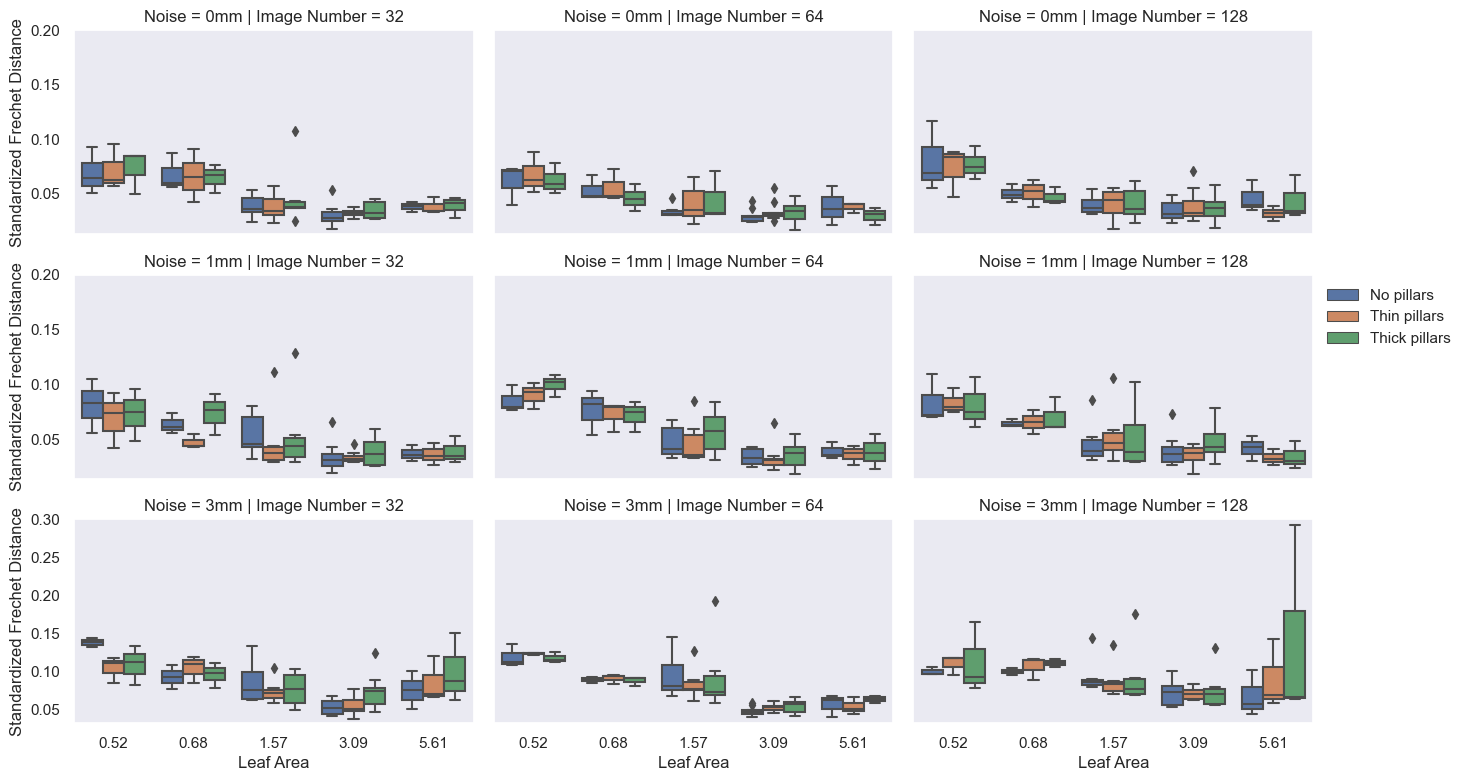

In [115]:
col_list = df["Noise"].unique()
row_list = df["Image Number"].unique()[::-1]

rows, cols = 3, 3
_, ax = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(wspace=0.05)
ylim=(None,0.3)
for i, col_name in enumerate(col_list):
    for j, row_name in enumerate(row_list):
        df_part = df[(df["Image Number"]==row_name) & (df["Noise"]==col_name)]
        if i==2:
            sns.boxplot(data=df_part, x="Leaf Area", y="Standardized Frechet Distance", hue="Dataset",
                       ax=ax[i, j]).set(title="Noise = " + col_name +" | "+ "Image Number = " + str(row_name), ylim=ylim)
        else:
            sns.boxplot(data=df_part, x="Leaf Area", y="Standardized Frechet Distance", hue="Dataset",
                       ax=ax[i, j]).set(title="Noise = " + col_name +" | "+ "Image Number = " + str(row_name), ylim=(None,0.2))
        
        if (i == 2) and (j==0):
            ax[i, j].set_xlabel('Leaf Area')
            ax[i, j].set_ylabel('Standardized Frechet Distance')
            
        elif i == 2:
            ax[i, j].set_xlabel('Leaf Area')
            ax[i, j].set_ylabel('')
            ax[i, j].tick_params(labelbottom=True, labelleft=False, labelright=False, labeltop=False)
            
        elif j == 0:
            ax[i, j].set_xlabel('')
            ax[i, j].set_ylabel('Standardized Frechet Distance')
            ax[i, j].tick_params(labelbottom=False, labelleft=True, labelright=False, labeltop=False)
            
        else:
            ax[i, j].set_xlabel('')
            ax[i, j].set_ylabel('')
            ax[i, j].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        
        if (i == 1) & (j == 2):
            handles, labels = ax[i,j].get_legend_handles_labels()
            ax[i,j].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
        else:
            ax[i,j].get_legend().remove()

In [98]:
ax[0,0].legend()

In [ ]:
# y軸のタイトル　左　のみ i = 0
# x軸のタイトル　下　のみ j = 2
